In [30]:
import pandas as pd
import yfinance as yf
import seaborn as sns
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from datetime import date
d2 = date.today() - timedelta(days=100)
d2 = d2.strftime("%Y-%m-%d")
plt.rcParams['figure.figsize'] = [20, 10]

In [31]:
def lines():
    for y, color, linestyle in [(0, 'black', '-'),
                                (1.0, 'green', '-'),
                                (2.5, 'green', '--'),
                                (3, 'magenta', '--'),
                                (-1.0, 'red', '--'),
                                (-2.5, 'red', '--'),
                                (-3, 'magenta', '--')]:
        plt.axhline(y=y, color=color, linestyle=linestyle)

In [32]:
path =r"C:\Users\Aashi\Quant\Session 1\ind_nifty500list.csv"
tickers=pd.read_csv(path)
tickers['Symbol']=tickers['Symbol']+str('.NS')
download=(tickers['Symbol'].to_list())

In [33]:
df=yf.download(tickers=download,start=d2)['Close']

[*********************100%***********************]  501 of 501 completed


In [34]:
df.fillna(method='bfill',inplace=True)

C:\Users\Aashi\AppData\Local\Temp\ipykernel_10508\1626352436.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill',inplace=True)


In [35]:
# Calculate percentage change
df2 = df.pct_change().dropna() #df2 has all the percentage changes, pct_change() is a function of pandas

# Calculate correlation matrix
corr = df2.corr() 

# Print the columns of the correlation DataFrame
#print("Columns in correlation DataFrame:", corr.columns)
# Solution: Rename the index before resetting
corr.index.name = None  # Temporarily remove the index name
corr_long = corr.stack().reset_index()  # Now stack and reset index
corr_long.columns = ['stock1', 'stock2', 'correlation']  # Rename columns for clarity

# Optionally, drop duplicate pairs (if you want unique pairs)
corr_long = corr_long[corr_long['stock1'] < corr_long['stock2']]

# Display the long format DataFrame
print("\nLong Format Correlation DataFrame:")
print(corr_long)


Long Format Correlation DataFrame:
               stock1         stock2  correlation
1           360ONE.NS     3MINDIA.NS     0.031027
2           360ONE.NS    AARTIIND.NS     0.178440
3           360ONE.NS       AAVAS.NS     0.023571
4           360ONE.NS         ABB.NS     0.171122
5           360ONE.NS  ABBOTINDIA.NS     0.187191
...               ...            ...          ...
249496  ZENSARTECH.NS      ZOMATO.NS     0.066928
249497  ZENSARTECH.NS   ZYDUSLIFE.NS     0.354441
249997   ZFCVINDIA.NS      ZOMATO.NS     0.168181
249998   ZFCVINDIA.NS   ZYDUSLIFE.NS     0.046008
250499      ZOMATO.NS   ZYDUSLIFE.NS     0.173896

[125250 rows x 3 columns]


<Axes: xlabel='Ticker'>

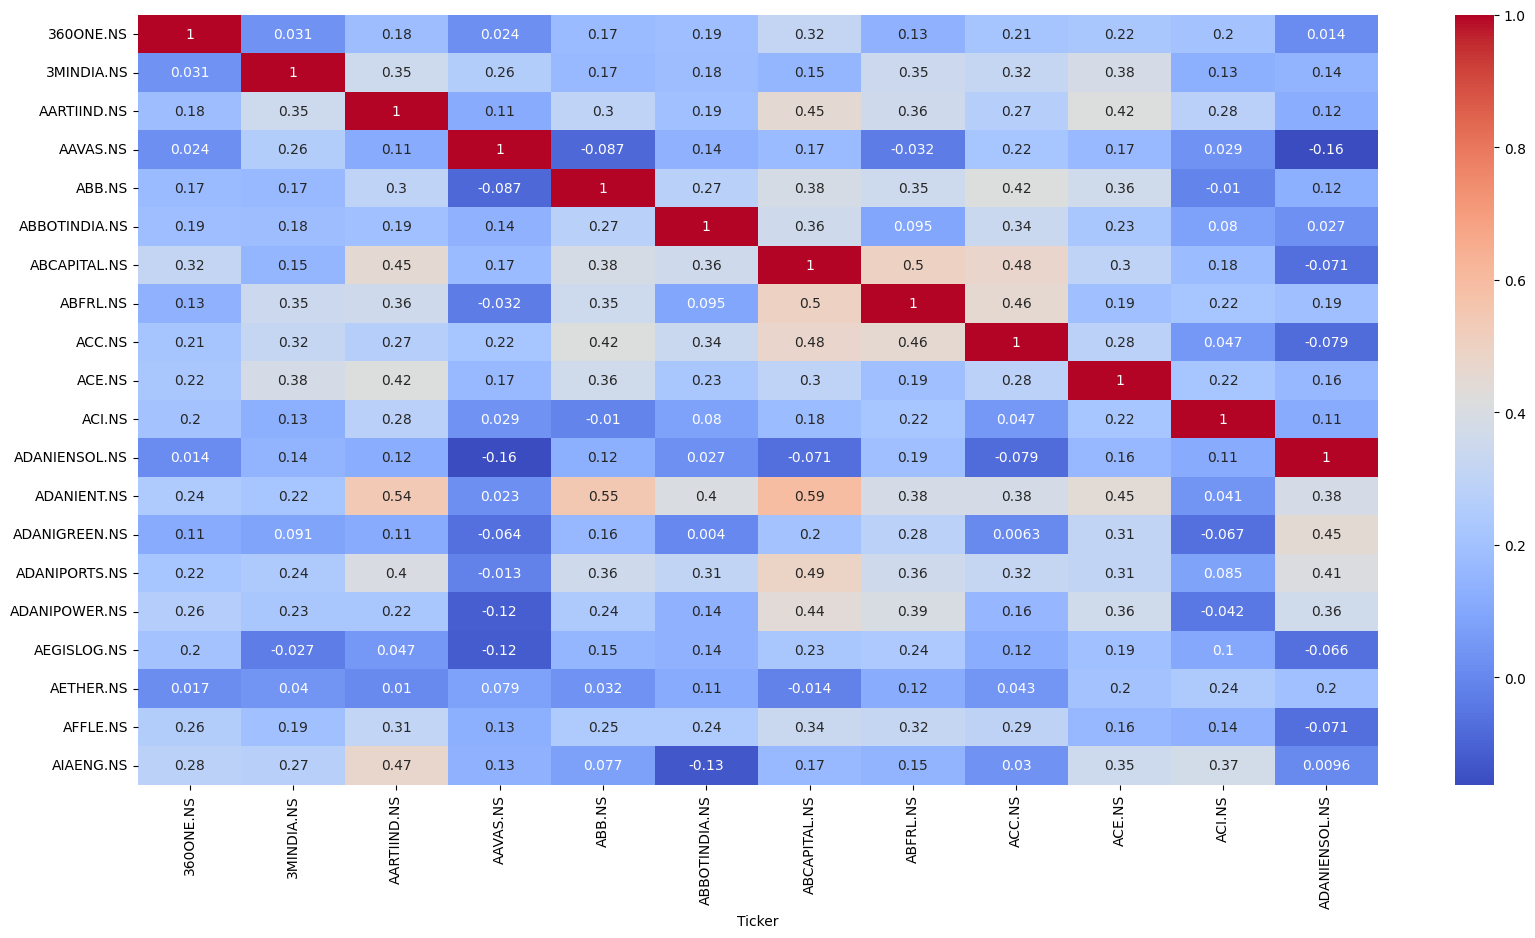

In [36]:
sns.heatmap(corr.iloc[:20, :12]
, annot=True, cmap='coolwarm')

In [39]:
Finale=corr_long.loc[corr_long['correlation']!=1] #same stock correlated with same data dropped
Finale=Finale.sort_values(by='correlation', ascending=False) #to see major correlated ones first
Finale=Finale.drop_duplicates('correlation') #

In [40]:
Finale=Finale.loc[Finale['correlation']>0.5] #no logic behind taking 0.5, only taking to shorten dataframe

In [41]:
Finale

,stock1,stock2,correlation
109437,IDFC.NS,IDFCFIRSTB.NS,0.924511
119478,IRCON.NS,IRFC.NS,0.909742
117706,IOB.NS,UCOBANK.NS,0.894154
180249,PFC.NS,RECLTD.NS,0.891647
77543,FACT.NS,RCF.NS,0.882297
...,...,...,...
26442,BAJAJHLDNG.NS,RECLTD.NS,0.500302
200362,RTNINDIA.NS,TRENT.NS,0.500212
14299,ANGELONE.NS,KEI.NS,0.500179
94431,GSFC.NS,ITI.NS,0.500117


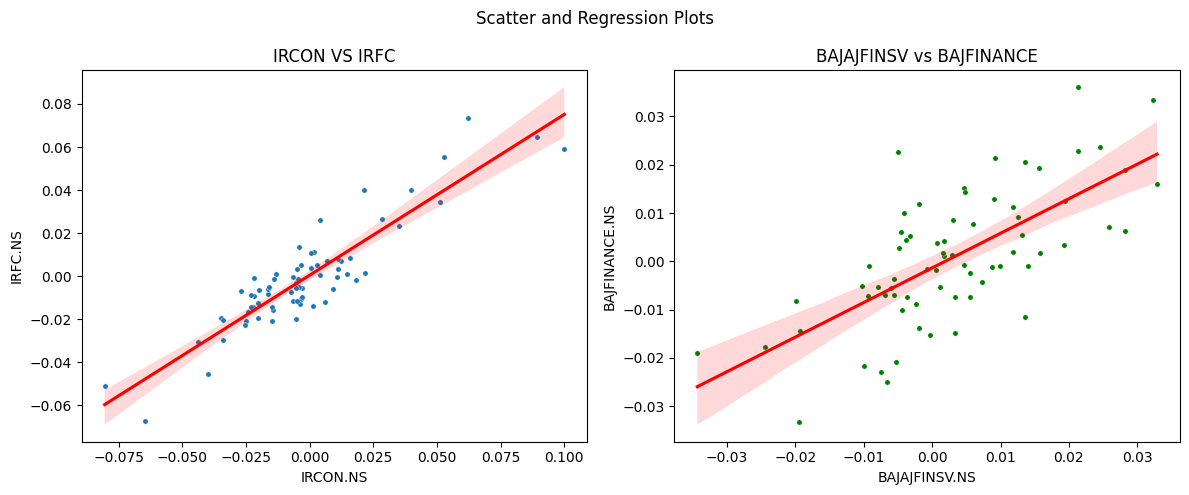

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# First subplot
sns.scatterplot(x=df2['IRCON.NS'], y=df2['IRFC.NS'], data=df, ax=ax1,s=15)
sns.regplot(x=df2['IRCON.NS'], y=df2['IRFC.NS'], data=df, color='red', scatter=False, ax=ax1)
ax1.set_xlabel('IRCON.NS')
ax1.set_ylabel('IRFC.NS')
ax1.set_title('IRCON VS IRFC')

# Second subplot
sns.scatterplot(x=df2['BAJAJFINSV.NS'], y=df2['BAJFINANCE.NS'], data=df, ax=ax2,s=15,color='green')
sns.regplot(x=df2['BAJAJFINSV.NS'], y=df2['BAJFINANCE.NS'], data=df, color='red', scatter=False, ax=ax2)
ax2.set_xlabel('BAJAJFINSV.NS')
ax2.set_ylabel('BAJFINANCE.NS')
ax2.set_title('BAJAJFINSV vs BAJFINANCE')

fig.suptitle('Scatter and Regression Plots')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
##Take the pairs and convert them to numpy arrays
stock1=np.array(df[Finale['stock1'].iloc[60]]) 
stock2=np.array(df[Finale['stock2'].iloc[60]]) 



##Correlation

correlation=(df2[Finale['stock1'].iloc[0]]).corr(df2[Finale['stock2'].iloc[0]])
##Perform Linear Regression 
reg=np.polyfit(stock1,stock2, deg=1) #line of regression
reg
trend=np.polyval(reg,stock1) #trend of correlation

##Calculate residuals for ADF test

ratio=stock1/stock2

ratio=stats.zscore(ratio) #z value

##Perform the ADF test
series = ratio
X = series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if(result[1]<0.05):
    print("ADF test passed")
else:
    print("ADF test failed")

ADF Statistic: -1.020758
p-value: 0.745618
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
ADF test failed
